In [1]:
import pymongo
import pandas as pd
import numpy as np
from scipy import stats
from datetime import datetime

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import linear_model

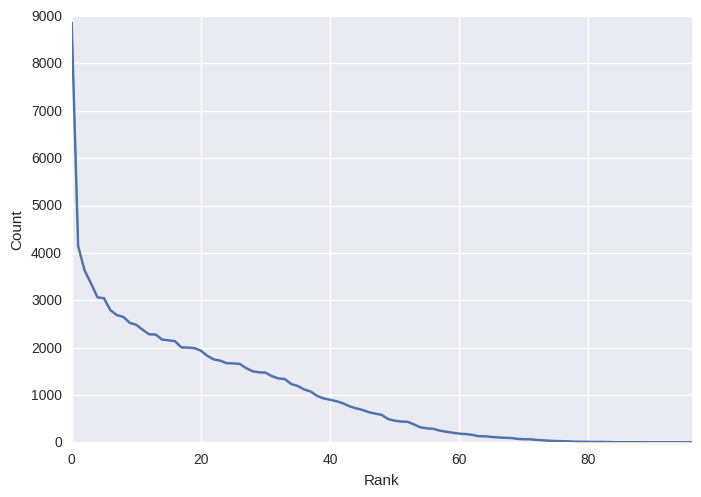

_id_track             99488
release_date_epoch    99488
album_type            99488
explicit              99488
duration_ms           99488
danceability          99488
energy                99488
instrumentalness      99488
key                   99488
liveness              99488
loudness              99488
mode                  99488
speechiness           99488
tempo                 99488
time_signature        99488
valence               99488
popularity_track      99488
dtype: int64
_id_track             8866
release_date_epoch    8866
album_type            8866
explicit              8866
duration_ms           8866
danceability          8866
energy                8866
instrumentalness      8866
key                   8866
liveness              8866
loudness              8866
mode                  8866
speechiness           8866
tempo                 8866
time_signature        8866
valence               8866
popularity_track      8866
dtype: int64


In [18]:
df = pd.read_csv("/home/chris/Documents/spotify/spotify_sample.csv")
counts = df['popularity_track'].value_counts()
sns.tsplot(counts)
plt.xlabel("Rank")
plt.ylabel("Count")
plt.show()
print(df.count())
print(df.query('popularity_track == 0').count())

In [4]:
def remove_album_dups(albums):
    unique_albums = {}
    for i, album in albums.iterrows():
        key = tuple([album['name'], album['release_date'], album['album_type']] + album['artists'])
        if (key not in unique_albums) or (unique_albums[key]['popularity'] < album['popularity']):
            unique_albums[key] = album

    return pd.DataFrame(list(unique_albums.values()))

In [ ]:
client = pymongo.MongoClient()
spotify_db = client.spotify

# Converts the data stored in mongo into dataframes
artists = pd.DataFrame(list(spotify_db.artists.find()))
albums = pd.DataFrame(list(spotify_db.albums.find()))
tracks = pd.DataFrame(list(spotify_db.tracks.find()))

In [ ]:
# Prints out the column headers of each collection to see what data is available

print(artists.columns.values)
print(albums.columns.values)
print(tracks.columns.values)

In [29]:
# Removes duplicate versions of albums 
albums = remove_album_dups(albums)

# Removes some unnecessary columns from each of the dataframes
artists = artists[['_id', 'name', 'followers', 'popularity']]
albums = albums[['_id', 'name', 'artists', 'album_type', 'release_date', 'popularity']]
tracks = tracks[['_id', 'name', 'album', 'danceability', 'duration_ms', 'energy', 'explicit',
                 'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'popularity', 
                 'speechiness', 'tempo', 'time_signature', 'valence']]

# Extracts the first artist of an album to merge on
albums['first_artist'] = albums['artists'].apply(lambda x: x[0])

In [40]:
joined = tracks.merge(
        albums, left_on="album", right_on="_id", suffixes=("_track", "_album")
    ).merge(
        artists, left_on="first_artist", right_on="_id", suffixes=("_track_album", "_artist")
    )

joined = joined[['_id', 'name', 'followers', 'popularity',
            '_id_album', 'name_album', 'album_type', 'release_date', 'popularity_album', 
            '_id_track', 'name_track', 'popularity_track', 'explicit', 'duration_ms',
            'danceability', 'energy', 'instrumentalness', 'key', 'liveness', 'loudness', 
            'mode', 'speechiness', 'tempo', 'time_signature', 'valence']]

joined.dropna(inplace=True)

In [ ]:
joined.to_csv("spotify.csv", date_format="%Y-%m-%d")

In [42]:
joined.sort_values(['popularity_track'], ascending=False).head(50)

,_id,name,followers,popularity,_id_album,name_album,album_type,release_date,popularity_album,_id_track,...,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
73848,6eUKZXaKkcviH0Ku9w2n3V,Ed Sheeran,8711573,99,7oJa8bPFKVbq4c7NswXHw8,Shape of You,single,2017-01-06,87,0FE9t6xYkqWXU2ahLh6D8X,...,0.652,0.000000,1.0,0.0931,-3.183,0.0,0.0802,95.977,4.0,0.9330
42258,69GGBxA162lTqCwzJG5jLp,The Chainsmokers,2417964,93,7IzpJkWQqgz1BTutQvSitX,Something Just Like This,single,2017-02-22,87,1dNIEtp7AY3oDAKCGg2XkH,...,0.649,0.000025,11.0,0.1740,-6.695,0.0,0.0362,102.996,4.0,0.4700
73693,6eUKZXaKkcviH0Ku9w2n3V,Ed Sheeran,8711573,99,3T4tUhGYeRNVUGevb0wThu,÷ (Deluxe),album,2017-03-03,100,7qiZfU4dY1lWllzX7mPBI3,...,0.652,0.000000,1.0,0.0931,-3.183,0.0,0.0802,95.977,4.0,0.9330
84046,0du5cEVh5yTK9QJze8zA0C,Bruno Mars,6095575,90,4PgleR09JVnm3zY1fW3XBA,24K Magic,album,2016-11-17,90,0KKkJNfGyhkQ5aFogxQAPU,...,0.560,0.000000,1.0,0.0944,-4.961,1.0,0.0406,134.066,4.0,0.8530
73695,6eUKZXaKkcviH0Ku9w2n3V,Ed Sheeran,8711573,99,3T4tUhGYeRNVUGevb0wThu,÷ (Deluxe),album,2017-03-03,100,0afhq8XCExXpqazXczTSve,...,0.876,0.000000,9.0,0.3270,-3.374,1.0,0.1000,99.943,4.0,0.7670
31238,23fqKkggKUBHNkbKtXEls4,Kygo,1417685,87,0IUCAsckpNyV4wHKIHQawC,It Ain't Me (with Selena Gomez),single,2017-02-16,86,3eR23VReFzcdmS7TYCrhCe,...,0.533,0.000000,0.0,0.0864,-6.596,1.0,0.0706,99.968,4.0,0.5000
42259,69GGBxA162lTqCwzJG5jLp,The Chainsmokers,2417964,93,64vx3cUb97lQGlgt8zozWL,Paris,single,2017-01-13,85,15vzANxN8G9wWfwAJLLMCg,...,0.644,0.000000,2.0,0.0888,-6.763,1.0,0.0310,99.999,4.0,0.2600
154945,60d24wfXkVzDSfLS6hyCjZ,Martin Garrix,2336479,85,2v9rQe4F8fVSh5v8bAq0jF,Scared to Be Lonely,single,2017-01-27,85,3ebXMykcMXOcLeJ9xZ17XH,...,0.540,0.000000,1.0,0.2610,-7.786,0.0,0.0576,137.972,4.0,0.1900
65,1RyvyyTE3xzB2ZywiAwp0i,Future,2518310,93,4YtTX4GPvBvewbJvBfXCS2,FUTURE,album,2017-02-17,89,3rOSwuTsUlJp0Pu0MkN8r8,...,0.434,0.021900,2.0,0.1650,-8.795,1.0,0.4310,150.062,4.0,0.2860
38891,7CajNmpbOovFoOoasH2HaY,Calvin Harris,5980463,87,1UIlzhqJLiA3f6OVw7QKn6,Slide,single,2017-02-24,84,6gpcs5eMhJwax4mIfKDYQk,...,0.795,0.000001,1.0,0.2540,-3.299,0.0,0.0545,104.066,4.0,0.5080


In [41]:
joined['release_date_month'] = joined['release_date'].map(lambda x: 1000*x.year + x.month)

df_means = joined[['release_date_month', 'popularity_track']].groupby('release_date_month', as_index=False).aggregate(np.mean)

sns.lmplot('release_date_month', 'popularity_track',
           data=df_means,
           fit_reg=True)
plt.title('Life Expectancy Over Time')
plt.xlabel('Year')
plt.ylabel('Life Expectancy')

AttributeError: 'str' object has no attribute 'year'

In [7]:
clf = linear_model.LinearRegression()
clf.fit(X, y.reshape(-1, 1))

print(clf.intercept_)
[print('%s: %f' %(k.ljust(20), v)) for k, v in (zip(X.columns, clf.coef_[0]))]

#getStatistics(X, y, clf)

[ 16.90663847]
release_date        : 0.000000
explicit            : 4.715632
duration            : -0.000003
acousticness        : -4.767138
danceability        : 3.810119
energy              : 7.290646
instrumentalness    : -8.006597
key                 : -0.017071
liveness            : -5.908202
mode                : -0.983747
speechiness         : -10.651127
tempo               : 0.010331
time_signature      : 0.444126
valence             : -6.419162


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [8]:
clf = linear_model.SGDRegressor()
clf.fit(X, y)

print(clf.intercept_)
[print('%s: %f' %(k.ljust(20), v)) for k, v in (zip(X.columns, clf.coef_))]

getStatistics(X, y, clf)

[  7.10867261e+10]
release_date        : -271771434329088672.000000
explicit            : -283872234543.827881
duration            : -132369500485540.296875
acousticness        : -53192671632.809204
danceability        : 61112104882.367569
energy              : 62111602267.309677
instrumentalness    : 10120129255.742121
key                 : 523051912996.370605
liveness            : 187310967496.702148
mode                : -130132326831.973495
speechiness         : -48055267931.358932
tempo               : 7398782234383.071289
time_signature      : 231411624141.030945
valence             : 41672488293.715225
MSE: 99078933090470006101548876581793948547248163930505216.000000
MSR: 1433474003952925319591355118643132358717630161267913129984.000000
F: 14468.000000
P: 0.000000
